In [18]:
import sys
sys.path.append('..')

import torch
import trimesh
import numpy as np
import matplotlib.pyplot as plt

from renderers.pytorch3d_textured_renderer import TexturedIUVRenderer
from configs.poseMF_shapeGaussian_net_config import get_poseMF_shapeGaussian_cfg_defaults
from configs import paths

In [2]:
scans_pth = '/data/FAUST/training/scans/'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
pose_shape_cfg = get_poseMF_shapeGaussian_cfg_defaults()

In [5]:
pytorch3d_renderer = TexturedIUVRenderer(device=device,
                                         batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
                                         img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE,
                                         render_rgb=False,
                                         bin_size=32)

In [6]:
scan = torch.tensor(trimesh.load(f'{scans_pth}/tr_scan_000.ply',process=False).vertices).unsqueeze(0).to(device)

In [7]:
scan.shape

torch.Size([1, 176387, 3])

In [8]:
mean_cam_t = torch.tensor(pose_shape_cfg.TRAIN.SYNTH_DATA.MEAN_CAM_T,
                              device=device, dtype=torch.float32)
mean_cam_t = mean_cam_t[None, :].expand(1, -1)

In [9]:
mean_cam_t

tensor([[ 0.0000, -0.2000,  2.5000]], device='cuda:0')

In [10]:
texture_paths = paths.TRAIN_TEXTURES_PATH

In [12]:
texture_paths

'/data/hierprob3d/training/smpl_train_textures.npz'

In [13]:
!du -sh /data/hierprob3d/training/smpl_train_textures.npz

2.5G	/data/hierprob3d/training/smpl_train_textures.npz


In [14]:
textures = np.load(texture_paths)
grey_textures = textures['grey']
nongrey_textures = textures['nongrey']

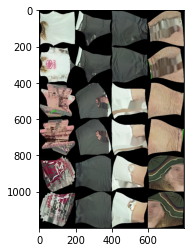

In [20]:
plt.imshow(nongrey_textures[0])

In [22]:
texture = nongrey_textures[10]
texture = torch.from_numpy(texture / 255.).float()

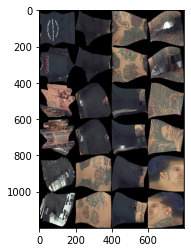

In [23]:
plt.imshow(texture)

In [25]:
texture = texture.unsqueeze(0)

In [28]:
texture.shape

torch.Size([1, 1200, 800, 3])

In [27]:
scan.shape

torch.Size([1, 176387, 3])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.io import loadmat

from configs import paths

import matplotlib.pyplot as plt

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    PointLights,
    RasterizationSettings,
    MeshRasterizer,
    MeshRenderer,
    HardPhongShader,
    TexturesUV,
    TexturesVertex,
    BlendParams)


def preprocess_densepose_UV(uv_path, batch_size):
    DP_UV = loadmat(uv_path)
    faces_bodyparts = torch.Tensor(DP_UV['All_FaceIndices']).squeeze()  # (13774,) face to DensePose body part mapping
    faces_densepose = torch.from_numpy((DP_UV['All_Faces'] - 1).astype(np.int64))  # (13774, 3) face to vertices indices mapping
    verts_map = torch.from_numpy(DP_UV['All_vertices'][0].astype(np.int64)) - 1  # (7829,) DensePose vertex to SMPL vertex mapping
    u_norm = torch.Tensor(DP_UV['All_U_norm'])  # (7829, 1)  # Normalised U coordinates for each vertex
    v_norm = torch.Tensor(DP_UV['All_V_norm'])  # (7829, 1)  # Normalised V coordinates for each vertex

    # RGB texture images/maps are processed into a 6 x 4 grid (atlas) of 24 textures.
    # Atlas is ordered by DensePose body parts (down rows then across columns).
    # UV coordinates for vertices need to be offset to match the texture image grid.
    offset_per_part = {}
    already_offset = set()
    cols, rows = 4, 6
    for i, u in enumerate(np.linspace(0, 1, cols, endpoint=False)):
        for j, v in enumerate(np.linspace(0, 1, rows, endpoint=False)):
            part = rows * i + j + 1  # parts are 1-indexed in face_indices
            offset_per_part[part] = (u, v)
    u_norm_offset = u_norm.clone()
    v_norm_offset = v_norm.clone()
    vertex_parts = torch.zeros(u_norm.shape[0])  # Also want to get a mapping between vertices and their corresponding DP body parts (technically one-to-many but ignoring that here).
    for i in range(len(faces_densepose)):
        face_vert_idxs = faces_densepose[i]
        part = faces_bodyparts[i]
        offset_u, offset_v = offset_per_part[int(part.item())]
        for vert_idx in face_vert_idxs:
            # vertices are reused (at DensePose part boundaries), but we don't want to offset multiple times
            if vert_idx.item() not in already_offset:
                # offset u value
                u_norm_offset[vert_idx] = u_norm_offset[vert_idx] / cols + offset_u
                # offset v value
                # this also flips each part locally, as each part is upside down
                v_norm_offset[vert_idx] = (1 - v_norm_offset[vert_idx]) / rows + offset_v
                # add vertex to our set tracking offsetted vertices
                already_offset.add(vert_idx.item())
        vertex_parts[face_vert_idxs] = part

    # invert V values
    v_norm = 1 - v_norm
    v_norm_offset = 1 - v_norm_offset

    # Combine body part indices (I), and UV coordinates
    verts_uv_offset = torch.cat([u_norm_offset[None], v_norm_offset[None]], dim=2).expand(batch_size, -1, -1)  # (batch_size, 7829, 2)
    verts_iuv = torch.cat([vertex_parts[None, :, None], u_norm[None], v_norm[None]], dim=2).expand(batch_size, -1, -1)  # (batch_size, 7829, 3)

    # Add a batch dimension to faces
    faces_densepose = faces_densepose[None].expand(batch_size, -1, -1)

    return verts_uv_offset, verts_iuv, verts_map, faces_densepose


class TexturedIUVRenderer(nn.Module):
    def __init__(self,
                 device,
                 batch_size,
                 img_wh=256,
                 cam_t=None,
                 cam_R=None,
                 projection_type='orthographic',
                 orthographic_scale=0.9,
                 blur_radius=0.0,
                 faces_per_pixel=1,
                 bin_size=None,
                 max_faces_per_bin=None,
                 perspective_correct=False,
                 cull_backfaces=False,
                 clip_barycentric_coords=None,
                 render_rgb=False,
                 light_t=((0.0, 0.0, -2.0),),
                 light_ambient_color=((0.5, 0.5, 0.5),),
                 light_diffuse_color=((0.3, 0.3, 0.3),),
                 light_specular_color=((0.2, 0.2, 0.2),),
                 background_color=(0.0, 0.0, 0.0)):
        """
        :param img_wh: Size of rendered image.
        :param blur_radius: Float distance in the range [0, 2] used to expand the face
            bounding boxes for rasterization. Setting blur radius
            results in blurred edges around the shape instead of a
            hard boundary.
            Set to 0 (no blur) if rendering for visualisation purposes.
        :param faces_per_pixel: Number of faces to save per pixel, returning
            the nearest faces_per_pixel points along the z-axis.
            Set to 1 if rendering for visualisation purposes.
        :param bin_size: Size of bins to use for coarse-to-fine rasterization (i.e
            breaking image into tiles with size=bin_size before rasterising?).
            Setting bin_size=0 uses naive rasterization; setting bin_size=None
            attempts to set it heuristically based on the shape of the input (i.e. image_size).
            This should not affect the output, but can affect the speed of the forward pass.
            Heuristic based formula maps image_size -> bin_size as follows:
                image_size < 64 -> 8
                16 < image_size < 256 -> 16
                256 < image_size < 512 -> 32
                512 < image_size < 1024 -> 64
                1024 < image_size < 2048 -> 128
        :param max_faces_per_bin: Only applicable when using coarse-to-fine rasterization
            (bin_size > 0); this is the maxiumum number of faces allowed within each
            bin. If more than this many faces actually fall into a bin, an error
            will be raised. This should not affect the output values, but can affect
            the memory usage in the forward pass.
            Heuristic used if None value given:
                max_faces_per_bin = int(max(10000, meshes._F / 5))
        :param perspective_correct: Bool, Whether to apply perspective correction when computing
            barycentric coordinates for pixels.
        :param cull_backfaces: Bool, Whether to only rasterize mesh faces which are
            visible to the camera.  This assumes that vertices of
            front-facing triangles are ordered in an anti-clockwise
            fashion, and triangles that face away from the camera are
            in a clockwise order relative to the current view
            direction. NOTE: This will only work if the mesh faces are
            consistently defined with counter-clockwise ordering when
            viewed from the outside.
        :param clip_barycentric_coords: By default, turn on clip_barycentric_coords if blur_radius > 0.
        When blur_radius > 0, a face can be matched to a pixel that is outside the face,
        resulting in negative barycentric coordinates.
        """
        super().__init__()
        self.img_wh = img_wh

        # UV pre-processing for textures
        verts_uv_offset, verts_iuv, verts_map, faces_densepose = preprocess_densepose_UV(uv_path=paths.DP_UV_PROCESSED_FILE, batch_size=batch_size)
        self.verts_uv_offset = verts_uv_offset.to(device)
        self.verts_iuv = verts_iuv.to(device)
        self.verts_map = verts_map.to(device)
        self.faces_densepose = faces_densepose.to(device)
        self.projection_type = projection_type

        # Cameras - pre-defined here but can be specified in forward pass if cameras will vary (e.g. random cameras)
        if cam_R is None:
            # Rotating 180° about z-axis to make pytorch3d camera convention same as what I've been using so far in my perspective_project_torch/NMR/pyrender
            # (Actually pyrender also has a rotation defined in the renderer to make it same as NMR.)
            cam_R = torch.tensor([[-1., 0., 0.],
                                  [0., 1., 0.],
                                  [0., 0., -1.]], device=device).float()
            cam_R = cam_R[None, :, :].expand(batch_size, -1, -1)
      
        # Pytorch3D camera is rotated 180° about z-axis to match my perspective_project_torch/NMR's projection convention.
        # So, need to also rotate the given camera translation (implemented below as elementwise-mul).
        cam_t = cam_t * torch.tensor([-1., -1., 1.], device=cam_t.device).float()

        self.cameras = FoVOrthographicCameras(device=device,
                                            R=cam_R,
                                            T=cam_t,
                                            scale_xyz=((
                                                orthographic_scale,
                                                orthographic_scale,
                                                1.0),))

        # Lights for textured RGB render - pre-defined here but can be specified in forward pass if lights will vary (e.g. random cameras)
        self.render_rgb = render_rgb
        if self.render_rgb:
            self.lights_rgb_render = PointLights(device=device,
                                                 location=light_t,
                                                 ambient_color=light_ambient_color,
                                                 diffuse_color=light_diffuse_color,
                                                 specular_color=light_specular_color)
        # Lights for IUV render - don't want lighting to affect the rendered image.
        self.lights_iuv_render = PointLights(device=device,
                                             ambient_color=[[1, 1, 1]],
                                             diffuse_color=[[0, 0, 0]],
                                             specular_color=[[0, 0, 0]])

        # Rasterizer
        raster_settings = RasterizationSettings(image_size=img_wh,
                                                blur_radius=blur_radius,
                                                faces_per_pixel=faces_per_pixel,
                                                bin_size=bin_size,
                                                max_faces_per_bin=max_faces_per_bin,
                                                perspective_correct=perspective_correct,
                                                cull_backfaces=cull_backfaces,
                                                clip_barycentric_coords=clip_barycentric_coords)
        self.rasterizer = MeshRasterizer(cameras=self.cameras, raster_settings=raster_settings)  # Specify camera in forward pass

        # Shader for textured RGB output and IUV output
        blend_params = BlendParams(background_color=background_color)
        self.iuv_shader = HardPhongShader(device=device, cameras=self.cameras,
                                          lights=self.lights_iuv_render, blend_params=blend_params)        
       
    def forward(self, vertices, textures=None, cam_t=None, orthographic_scale=None, lights_rgb_settings=None,
                verts_features=None):
        """
        Render a batch of textured RGB images and IUV images from a batch of meshes.

        Fragments output from rasterizer:
        pix_to_face:
          LongTensor of shape (B, image_size, image_size, faces_per_pixel)
          specifying the indices of the faces (in the packed faces) which overlap each pixel in the image.
        zbuf:
          FloatTensor of shape (B, image_size, image_size, faces_per_pixel)
          giving the z-coordinates of the nearest faces at each pixel in world coordinates, sorted in ascending z-order.
        bary_coords:
          FloatTensor of shape (B, image_size, image_size, faces_per_pixel, 3)
          giving the barycentric coordinates in NDC units of the nearest faces at each pixel, sorted in ascending z-order.
        pix_dists:
          FloatTensor of shape (B, image_size, image_size, faces_per_pixel)
          giving the signed Euclidean distance (in NDC units) in the x/y plane of each point closest to the pixel.

        :param vertices: (B, N, 3)
        :param textures: (B, tex_H, tex_W, 3)
        :param cam_t: (B, 3)
        :param orthographic_scale: (B, 2)
        :param lights_rgb_settings: dict of lighting settings with location, ambient_color, diffuse_color and specular_color.
        :returns rgb_images: (B, img_wh, img_wh, 3)
        :returns iuv_images: (B, img_wh, img_wh, 3) IUV images give bodypart (I) + UV coordinate information. Parts are DP convention, indexed 1-24.
        :returns depth_images: (B, img_wh, img_wh)
        """
#         if cam_t is not None:
#             # Pytorch3D camera is rotated 180° about z-axis to match my perspective_project_torch/NMR's projection convention.
#             # So, need to also rotate the given camera translation (implemented below as elementwise-mul).
#             self.cameras.T = cam_t * torch.tensor([-1., -1., 1.], device=cam_t.device).float()
        if orthographic_scale is not None and self.projection_type == 'orthographic':
            self.cameras.focal_length = orthographic_scale * (self.img_wh / 2.0)

#         if lights_rgb_settings is not None and self.render_rgb:
#             self.lights_rgb_render.location = lights_rgb_settings['location']
#             self.lights_rgb_render.ambient_color = lights_rgb_settings['ambient_color']
#             self.lights_rgb_render.diffuse_color = lights_rgb_settings['diffuse_color']
#             self.lights_rgb_render.specular_color = lights_rgb_settings['specular_color']

        vertices = vertices[:, self.verts_map, :]  # From SMPL verts indexing (0 to 6889) to DP verts indexing (0 to 7828), verts shape is (B, 7829, 3)

        textures_iuv = TexturesVertex(verts_features=self.verts_iuv)
        meshes_iuv = Meshes(verts=vertices, faces=self.faces_densepose, textures=textures_iuv)
        
#         if self.render_rgb:
#             if verts_features is not None:
#                 verts_features = verts_features[:, self.verts_map, :]  # From SMPL verts indexing (0 to 6889) to DP verts indexing (0 to 7828), verts shape is (B, 7829, 3)
#                 textures_rgb = TexturesVertex(verts_features=verts_features)
#             else:
#                 textures_rgb = TexturesUV(maps=textures, faces_uvs=self.faces_densepose, verts_uvs=self.verts_uv_offset)
#             meshes_rgb = Meshes(verts=vertices, faces=self.faces_densepose, textures=textures_rgb)

        # Rasterize
        fragments = self.rasterizer(meshes_iuv, cameras=self.cameras)
        zbuffers = fragments.zbuf[:, :, :, 0]

        # Render RGB and IUV outputs
        output = {}
        output['iuv_images'] = self.iuv_shader(fragments, meshes_iuv, lights=self.lights_iuv_render)[:, :, :, :3]
        if self.render_rgb:
            rgb_images = self.rgb_shader(fragments, meshes_rgb, lights=self.lights_rgb_render)[:, :, :, :3]
            output['rgb_images'] = torch.clamp(rgb_images, max=1.0)

        # Get depth image
        output['depth_images'] = zbuffers

        return output

In [ ]:
cam_R = torch.tensor([[-1., 0., 0.],
                                  [0., 1., 0.],
                                  [0., 0., -1.]], device=device).float()
cam_R = cam_R[None, :, :].expand(batch_size, -1, -1)

orthographic_scale = 0.9
raster_settings = RasterizationSettings(image_size=256,
                                        blur_radius=blur_radius,
                                        faces_per_pixel=faces_per_pixel,
                                        bin_size=bin_size,
                                        max_faces_per_bin=max_faces_per_bin,
                                        perspective_correct=perspective_correct,
                                        cull_backfaces=cull_backfaces,
                                        clip_barycentric_coords=clip_barycentric_coords)

cameras = FoVOrthographicCameras(device=device,
                                R=cam_R,
                                T=mean_cam_t,
                                scale_xyz=((
                                    orthographic_scale,
                                    orthographic_scale,
                                    1.0),))
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
fragments = rasterizer(meshes_iuv, cameras=self.cameras)
zbuffers = fragments.zbuf[:, :, :, 0]

In [29]:
renderer_output = pytorch3d_renderer(vertices=scan,
                                     textures=None,
                                     cam_t=mean_cam_t,
                                     lights_rgb_settings=None)

ValueError: Textures do not match the dimensions of Meshes.

In [ ]:
renderer_output['depth']

In [ ]:
plt.imshow(np.array(depth_in[0,0].cpu().detach()))